# Vision Language Model Integration with ROS 2

In this notebook, we will introduce Vision Language Models (VLMs). Then we will integrate a Llama.cpp run VLM with ROS 2 via a service node.

In the NPU section we showed how to integrate hardware acceleration in a publisher/subscriber pipeline, here we will set up a VLM service using ROS 2's request/response pattern.

## Goals

* Use Llama.cpp to serve up a VLM endpoint
* Integrate a local VLM as a ROS 2 service using Python RCL
* See the tradeoffs between smaller and more powerful models for more cognitive robotics tasks

## References

* [Understanding ROS 2 Services](https://docs.ros.org/en/kilted/Tutorials/Beginner-CLI-Tools/Understanding-ROS2-Services/Understanding-ROS2-Services.html)
* [llama.cpp Multimodal Documentation](https://github.com/ggml-org/llama.cpp/blob/master/docs/multimodal.md)

## Start llama.cpp Server

Before we can use the VLM service, we need to start the llama.cpp server with a vision-language model. The server provides an OpenAI-compatible API endpoint that our ROS node will communicate with.

**In a separate terminal**, start the llama.cpp server with a VLM model:

![](images/new_terminal.png)

```bash
unset HSA_OVERRIDE_GFX_VERSION
export PATH=/ryzers/llamacpp/build/bin/:$PATH
llama-server -hf ggml-org/SmolVLM-500M-Instruct-GGUF \
  --host 0.0.0.0 \
  --port 8080
```

Wait until you see the "server listening" message before proceeding.

```
main: server is listening on http://0.0.0.0:8080 - starting the main loop
```

**What this does:**
- Downloads the model if not already cached (stored in `~/.cache/huggingface/`)
- Loads the model into memory
- Starts an HTTP server on port 8080 with OpenAI-compatible endpoints
- Ready to accept image + text queries for VLM inference

## Test OpenAI API Server Directly

Before integrating with ROS, let's verify the llama.cpp server is working correctly by making a direct API call. This helps us understand the request/response format and confirm the VLM is functioning properly.

The OpenAI-compatible API uses a chat completions format with messages containing both text and images. Note that we have to base64 encode our image.

In [1]:
import base64
import json
import requests
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from utils import plot_image

LLAMA_SERVER_URL = "http://0.0.0.0:8080/v1/chat/completions"

def b64_image(image_path: str) -> str:
    """Convert image to base64 string"""
    data = Path(image_path).read_bytes()
    return base64.b64encode(data).decode("utf-8")

def ask_with_image(image_path: str, question: str):
    """Query VLM with image and question using OpenAI format"""
    payload = {
        "model": "smolvlm",
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": question},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{b64_image(image_path)}"}}
                ]
            }
        ],
        "temperature": 0.2,
        "max_tokens": 256
    }
    
    r = requests.post(LLAMA_SERVER_URL, json=payload, timeout=120)
    r.raise_for_status()
    resp = r.json()
    
    # Display image
    img = cv2.imread(image_path)
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(resp["choices"][0]["message"]["content"])

Now let's prompt the SmolVLM model with an image of a bird and see what it says!

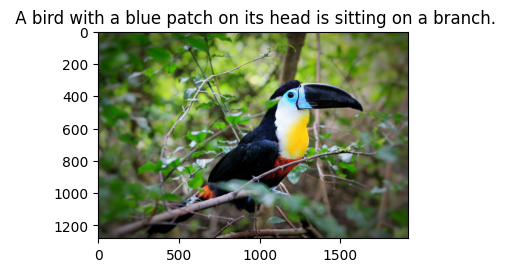

In [2]:
ask_with_image("images/toucan.jpg", "What's in this image? Be concise.")

## `vlm_ros` Package

The `vlm_ros` package provides a ROS 2 service for querying vision-language models through llama.cpp. This allows you to leverage multimodal AI within the familiar ROS ecosystem. It's implemented as a wrapper of the code we just ran to prompt our Llama.cpp server directly.

### Package Features

The package includes:

- **vlm_node**: ROS 2 service server that processes VLM queries
- **VLMQuery service**: Clean request/response interface (image + prompt → response)
- **OpenAI-compatible API**: Uses the standard `/v1/chat/completions` endpoint

## Explore the Package Structure

Let's examine the `vlm_ros` package structure. It follows ROS 2 conventions with a service definition (`srv/VLMQuery.srv`) and the service implementation (`vlm_ros/vlm_node.py`).

In [3]:
!ls vlm_ros/

build		install      resource	setup.py  vlm_ros
CMakeLists.txt	package.xml  setup.cfg	srv


The service structure is very simple - our node will take published pictures and prompts as an input, then wait to receive a text response from the VLM.

In [4]:
!cat vlm_ros/srv/VLMQuery.srv

# Request
sensor_msgs/Image image
string prompt
---
# Response
string response


## Start the VLM Service

The package is already built so we don't need to worry about that.

We can launch the VLM service node. This node provides a ROS 2 service at `/vlm_query` that accepts an image and prompt, then returns the VLM response.

**In a separate terminal**, run the VLM service:

![](images/new_terminal.png)

```bash
source /opt/ros/kilted/setup.bash
source /ryzers/notebooks/vlm_ros/install/setup.bash
ros2 run vlm_ros vlm_node
```

You should see this output:

```
[INFO] [1761087384.672710670] [vlm_node]: vlm_ros service ready on /vlm_query (llama.cpp at http://localhost:8080)
```

This confirms the service is running and ready to process requests.

## VLM Service Tester

Below is a simple implemention to test the service node. This is the type of communication you would be using in your own application.

In [5]:
# uncomment below if issues with importing VLMQuery
# from utils import ros_setup
# ros_setup("/ryzers/notebooks/vlm_ros/install")
import rclpy
from rclpy.node import Node
from vlm_ros.srv import VLMQuery
from cv_bridge import CvBridge
import cv2

class VLMTester(Node):
    """Test node to call VLM service"""
    def __init__(self):
        super().__init__('vlm_tester')
        self.client = self.create_client(VLMQuery, 'vlm_query')
        self.bridge = CvBridge()
        
        # Wait for service to be available
        while not self.client.wait_for_service(timeout_sec=1.0):
            self.get_logger().info('Waiting for VLM service...')
        
        print("VLM tester initialized, service ready")
        
    def query(self, image_path, prompt):
        """Query VLM with image and prompt"""
        # Load image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not load image: {image_path}")
            return None
        
        # Create request
        request = VLMQuery.Request()
        request.image = self.bridge.cv2_to_imgmsg(img, encoding='bgr8')
        request.prompt = prompt
        
        # Call service
        print(f"Querying: {prompt}")
        future = self.client.call_async(request)
        rclpy.spin_until_future_complete(self, future)
        
        if future.result() is not None:
            response = future.result().response
            print(f"\nResponse: {response}\n")
            return response
        else:
            print('Service call failed')
            return None

# Initialize ROS
rclpy.init()
tester = VLMTester()

VLM tester initialized, service ready


## Test with a Sample Image

Now we have a complete pipeline running:
- **llama.cpp server** serving the VLM model
- **vlm_node** providing the VLM service
- **vlm_tester** ready to call the service

Let's query the VLM with an image:

Querying: Describe what you see in this image.

Response:  Deer in a park with trees and cars in the background.



' Deer in a park with trees and cars in the background.'

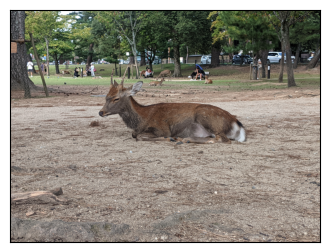

In [6]:
# Query with default prompt
plot_image("images/deer.jpg")
tester.query('images/deer.jpg', 'Describe what you see in this image.')

## Robot Planning with VLMs

Now let's do something more robotics related. VLMs play an important part in modern robot policies. They understand the physical world via images and it's not an uncommon setup to have a VLM running in tandem with another robot policy model.

Let's try to prompt our model to generate a low level plan to accomplish the simple task of putting a pen into a bowl.

Querying: Make a bullet point plan for the arm to put the pen into the bowl. Output only the bullets, nothing else. Use simple commands.

Response:  A pen, a plate, and a clamp lay on a black table.



' A pen, a plate, and a clamp lay on a black table.'

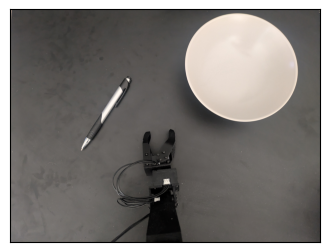

In [7]:
plot_image('images/pen_bowl.jpg')
tester.query('images/pen_bowl.jpg', 'Make a bullet point plan for the arm to put the pen into the bowl. Output only the bullets, nothing else. Use simple commands.')

### Why is it not following instructions?

Try re-prompting this a couple times giving the VLM different instructions. You'll notice this model is not the best at reasoning. That's because SmolVLM is a tiny 500M model mostly used to describe images rather than any heavy duty planning tasks.

## Change to a More Powerful Model

1. **Return to Llama.cpp terminal:** go to the terminal where you launched llama.cpp
2. **Kill the process:** `ctrl+c`, shut down the llama-server process
3. **Launch Gemma3:** run the following:
```
llama-server -hf ggml-org/gemma-3-4b-it-GGUF
```

Wait for the model to load. Make sure you see this before proceeding:
```
main: server is listening on http://127.0.0.1:8080 - starting the main loop
```

You don't need to restart the VLM service node, it will keep running and keep sending API requests to the same endpoint.

Now run the same command using Gemma3. The output should be what we requested.

Querying: Make a bullet point plan for the arm to put the pen into the bowl. Output only the bullets, nothing else. Use simple commands.

Response: *   Move arm to pen position.
*   Close gripper on pen.
*   Move arm to bowl position.
*   Open gripper to release pen.



'*   Move arm to pen position.\n*   Close gripper on pen.\n*   Move arm to bowl position.\n*   Open gripper to release pen.'

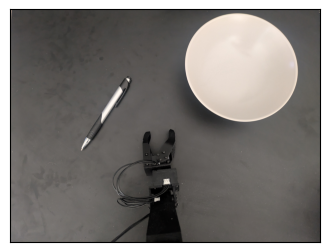

In [8]:
plot_image('images/pen_bowl.jpg')
tester.query('images/pen_bowl.jpg', 'Make a bullet point plan for the arm to put the pen into the bowl. Output only the bullets, nothing else. Use simple commands.')

Try some different scenes and objects

Querying: Make a bullet point plan for the arm to put the screws into the transparent container. Output only the bullets, nothing else. Use simple commands.

Response: *   Move arm to position above container.
*   Close gripper.
*   Lower gripper towards container.
*   Detect screw.
*   Open gripper slightly.
*   Move gripper to center of container.
*   Close gripper around screw.
*   Lower gripper into container.
*   Raise gripper slightly.
*   Open gripper fully.
*   Move arm back to starting position.



'*   Move arm to position above container.\n*   Close gripper.\n*   Lower gripper towards container.\n*   Detect screw.\n*   Open gripper slightly.\n*   Move gripper to center of container.\n*   Close gripper around screw.\n*   Lower gripper into container.\n*   Raise gripper slightly.\n*   Open gripper fully.\n*   Move arm back to starting position.'

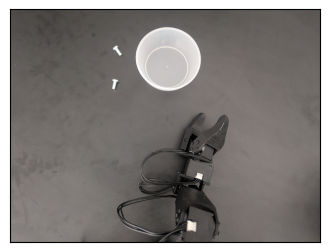

In [9]:
plot_image('images/container_screws.jpg')
tester.query('images/container_screws.jpg', 'Make a bullet point plan for the arm to put the screws into the transparent container. Output only the bullets, nothing else. Use simple commands.')

Clearly Gemma produces much better outputs (i.e. what we asked for), however it's at the cost of ~8x parameters than SmolVLM. This requires that much more memory and compute.

## Key Takeaways

Congratulations! You've successfully built a VLM-powered ROS 2 pipeline! You now understand:

* How to run llama.cpp server with vision-language models
* The OpenAI-compatible API format for multimodal requests
* How to integrate VLMs into ROS 2 using request/response patterns
* Large VLMs are better at reasoning than small ones, but they cost more compute

## Next Steps

* Play around with different prompts to see how the models respond
* Try uploading your own images
* Experiment with various VLM models to see quality vs. speed tradeoffs, e.g:

```bash
# Smaller, faster model
llama-server -hf ggml-org/SmolVLM-256M-Instruct-GGUF

# Larger, more powerful model
llama-server -hf ggml-org/gemma-3-4b-it-GGUF
```

* (At home) Connect a real camera using `v4l2_camera` or `image_tools` packages


## Cleanup

Make sure to `ctrl+c` and close the terminals before moving onto the next notebook.

**Continue to:** [4_robot_policies.ipynb](4_robot_policies.ipynb)



---
Copyright© 2025 AMD, Inc SPDX-License-Identifier: MIT